In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import fastcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [2]:
# Configuración de números flotantes a 3 decimales
pd.set_option('display.float_format','{:.2f}'.format)

# Estilo de visualización
sns.set_style("darkgrid")#, {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
RFM_DATA_PATH = os.path.join('..','datasets','processed','rfm_dataset.csv')
data = pd.read_csv(RFM_DATA_PATH, index_col='Customer ID') # RFM dataset
data.sample(5)

,Recency,Frequency,MonetaryValue
Customer ID,,,
GH-14665,3,3,-5.81
LH-16750,152,3,12.63
JH-15910,42,9,-13.55
KW-16435,97,10,1756.13
VF-21715,14,11,-96.28


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,793.00,147.80,186.21,1.00,31.00,76.00,184.00,1166.00
Frequency,793.00,12.60,6.24,1.00,8.00,12.00,16.00,37.00
MonetaryValue,793.00,361.16,894.26,-6626.39,36.61,227.83,560.01,8981.32


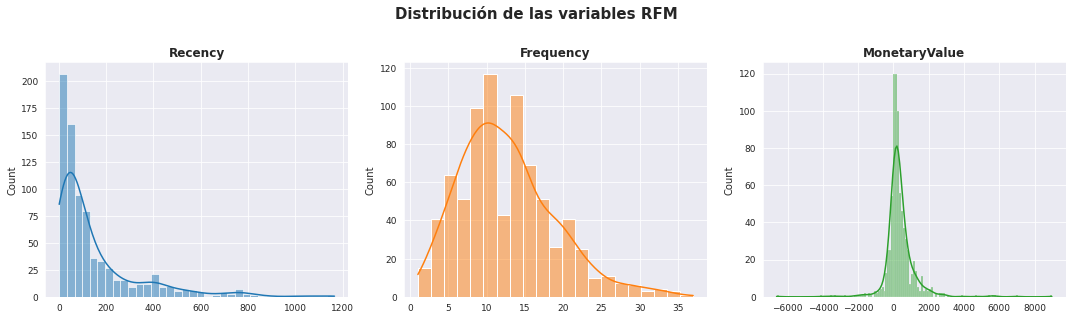

In [5]:
%run ../auxiliar_functions/plotDistributions.py
    
plotDistributions(data, 'Distribución de las variables RFM')

In [6]:
# Elimino los valors negtivos
data.drop(data[data['MonetaryValue'] < 0].index, inplace=True)

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,638.00,140.99,177.80,1.00,30.00,73.00,168.50,1166.00
Frequency,638.00,12.88,6.32,1.00,9.00,12.00,16.00,37.00
MonetaryValue,638.00,560.54,789.10,0.11,150.46,315.87,682.89,8981.32


### Transformación de los datos

In [8]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log1p(X)


mm_transformer = MinMaxScaler()
log_transformer = LogTransformer()

transformer = ColumnTransformer(transformers=[('log-transform', log_transformer, ['Recency']),
                              ('standarizer', mm_transformer, ['Frequency', 'MonetaryValue'])])

scaled = transformer.fit_transform(data)

# Variables escaladas - DataFrame
scaled = pd.DataFrame(scaled, index=data.index, columns=data.columns)
scaled.sample(5)

,Recency,Frequency,MonetaryValue
Customer ID,,,
LP-17095,2.40,0.39,0.04
NP-18670,4.09,0.25,0.06
JF-15190,4.20,0.50,0.06
KB-16600,1.10,0.22,0.03
DR-12880,1.61,0.64,0.18


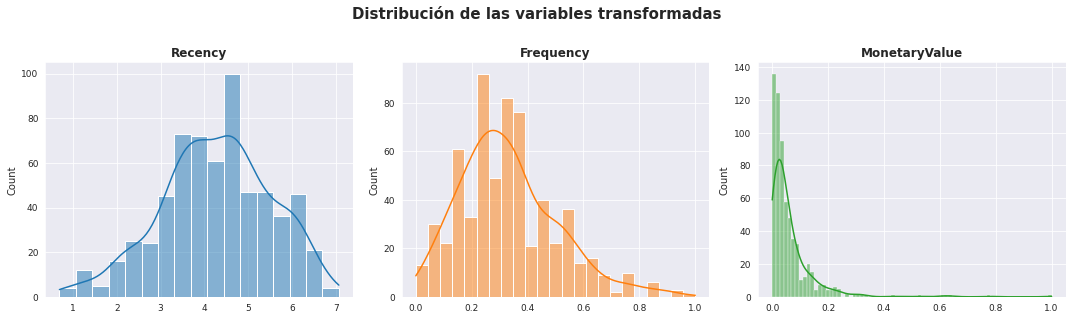

In [9]:
plotDistributions(scaled, 'Distribución de las variables transformadas')

In [10]:
scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,638.00,4.27,1.26,0.69,3.43,4.30,5.13,7.06
Frequency,638.00,0.33,0.18,0.00,0.22,0.31,0.42,1.00
MonetaryValue,638.00,0.06,0.09,0.00,0.02,0.04,0.08,1.00


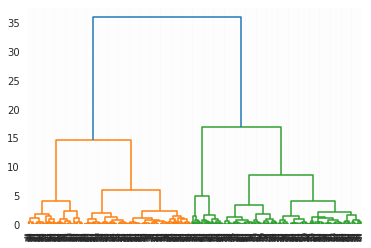

In [11]:
# Modelo de segmentación jerárquica
hierarchy_model = fastcluster.linkage_vector(scaled, method='ward', metric='euclidean')

# Dendrograma
dendrogram = dendrogram(hierarchy_model)

# Visualización del dendrograma
plt.xlabel(None)
plt.show()

In [12]:
# Punto de corte
cluster_labels = fcluster(hierarchy_model, t=10, criterion='distance')

hierarchicalData = data.copy()

# Asignación de las etiquetas de clusters a los datos
hierarchicalData['ClusterLabels_H'] = cluster_labels

hierarchicalData = hierarchicalData.groupby('ClusterLabels_H').agg({'Recency':['mean', 'std'],
                                                   'Frequency':['mean',  'std'],
                                                   'MonetaryValue':['mean','std']})


hierarchicalData

Recency        Frequency      MonetaryValue        
                   mean    std      mean  std          mean     std
ClusterLabels_H                                                    
1                473.04 189.70      9.68 6.15        520.87 1076.52
2                136.69  47.86     13.21 5.87        555.39  754.00
3                  6.30   2.97     13.77 5.37        681.80  706.21
4                 39.11  17.15     13.73 6.54        553.22  691.07

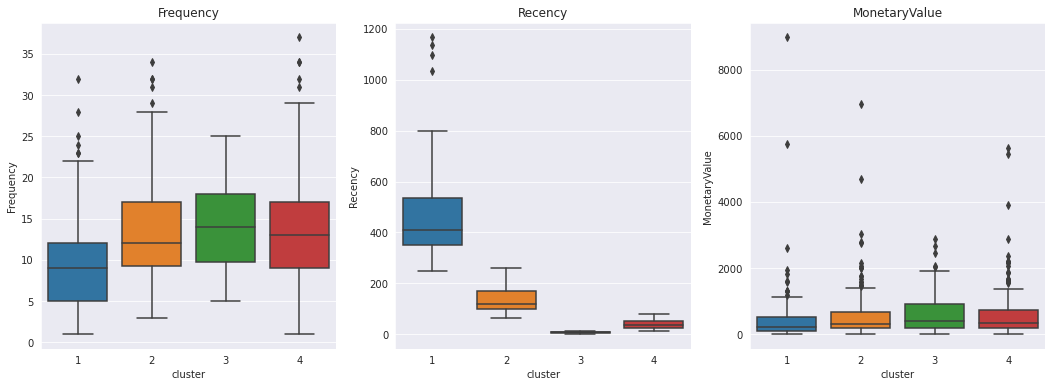

In [13]:
data['cluster'] = cluster_labels
fig, ax = plt.subplots(1,3, figsize=(18,6))
for i, feat in enumerate(['Frequency','Recency','MonetaryValue']):
    sns.boxplot(x='cluster', y=feat, data=data,ax=ax[i])
    ax[i].set_title(feat)
    
    
plt.savefig(os.path.join('..','img','hierachical_clusters_boxplots_dist.png'))
plt.show()